In [1]:
import os
import numpy as np
import pandas as pd
from starfit import Single, DB
from starfit.autils.stardb import StarDB
from starfit.autils.abusets import SolAbu
from starfit.utils import find_data

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import ptemcee

from concurrent.futures import as_completed
from concurrent.futures import ProcessPoolExecutor as Pool
from util import hostdir, hostname, element_list, element2z_dict
if hostname == 'jerome-linux':
    nthreads = os.cpu_count()//2
else:
    nthreads = 30

ImportError: cannot import name 'hostdir' from 'util' (/ssd/jiangrz/GitHub/rproc/util.py)

In [ ]:
import emcee, corner
from common import stardir_dict, resdir_dict, df_combine, \
    max_ns_list, str_max_ns_dict, max_rem_dict, \
    fitn_threshold, figdir
from utils import gridM_dict, edgeM_dict, gridE_dict, edgeE_dict, pareto, lognorm, powerlaw,\
    gen_exprobmat, gen_exprobmat_e, log_likelihood_dict, theta_ndim_dict

In [ ]:
def pert_mission_topn(pert_path, n=10):
    sing_pert = Single(
        pert_path, db=db,  
        z_min=6, z_max=30,
        upper_lim=False, cdf=True, det=False, 
        silent=True)
    # choice = np.random.randint(n, size=5)
    # pert_bffit = sing_pert.sorted_fitness[:n][choice]
    # pert_bfind = sing_pert.sorted_stars[:n]['index'].reshape(-1)[choice]
    # pert_bfoff = sing_pert.sorted_stars[:n]['offset'].reshape(-1)[choice]
    pert_N = np.sum(~sing_pert.exclude_index)
    pert_bffit = sing_pert.sorted_fitness[:n]
    pert_bfind = sing_pert.sorted_stars[:n]['index'].reshape(-1)
    pert_bfoff = sing_pert.sorted_stars[:n]['offset'].reshape(-1)
    return pert_bffit, pert_bfind, pert_bfoff

def func_weight(data, bins):
    binsize = np.diff(bins)
    dist2edge = data.reshape(-1, 1) - bins[:-1].reshape(1, -1)
    dist2edge_positive = np.ma.masked_array(dist2edge, mask=dist2edge < 0)
    weight = binsize[np.argmin(dist2edge_positive, axis=-1)]
    return weight
def gen_bins(data):
    unique = np.unique(data).astype(float)
    unique_hdiff = np.diff(unique)/2
    unique_mid = unique[:-1] + unique_hdiff
    bins = np.concatenate((
        unique[[0, -1]], 
        unique_mid, 
    ))
    bins.sort()
    return bins
def gen_weight(data):
    wdata = func_weight(
        data[:, 0], gen_bins(P[:, 0]))*func_weight(
        data[:, 1], gen_bins(P[:, 1]))*func_weight(
        data[:, 2], gen_bins(P[:, 2]))
    return wdata

In [ ]:
db = 'znuc2012.S4.star.el.y.stardb.gz'
dbpath = find_data(DB, db)
db = StarDB(dbpath, silent=True)
sun = SolAbu('solas09.dat', silent=True)
raw_fielddata = db.fielddata
raw_fieldname = db.fieldnames#[db.fieldflags==0]
raw_model_abund = db.data
raw_element = [_ion.name().capitalize() for _ion in db.ions]
element_list_abvC = element_list[5:]
model_logeps_df = pd.DataFrame(columns=element_list_abvC)
fielddata_df = pd.DataFrame(columns=raw_fieldname)
for _abu, _el in zip(raw_model_abund.T, raw_element):
    if _el in element_list_abvC:
        model_logeps_df[_el] = np.log10(
            _abu, where=_abu>0, 
            out=np.full(len(_abu), np.nan))
for _fieldname in raw_fieldname:
    fielddata_df[_fieldname] = raw_fielddata[_fieldname]
maxns = 2.0
# fielddata_df = fielddata_df.loc[fielddata_df.loc[:, 'remnant']<=maxns, :]
M = np.array(model_logeps_df.values).astype(float)
# M = np.round(M, 4)
eM_vec = np.full(M.shape[-1], 0.0)
P = np.array(fielddata_df.values[:, :-1]).astype(float)
P[:, -1] = np.log10(P[:, -1], where=P[:, -1]>0, out=-3.2*np.ones(P.shape[0]))
P_low = np.min(P, axis=0)
P_high = np.max(P, axis=0)
mass_bins = gen_bins(P[:, 0])
energy_bins = gen_bins(P[:, 1])
mixing_bins = gen_bins(P[:, 2])
if maxns is not None:
    explodability = fielddata_df.loc[:, 'remnant']<=maxns
else:
    explodability = fielddata_df.loc[:, 'remnant']>0

map_P2M = {
    ','.join(['%.3f'%_pvec for _pvec in P[_idx]]): M[_idx, :] 
    for _idx in range(P.shape[0])}
map_P2zeta = {
    ','.join(['%.3f'%_pvec for _pvec in P[_idx]]): explodability[_idx]
    for _idx in range(P.shape[0])}
def f_P2M(P_vec):
    P2M_key = ','.join(['%.3f'%_pvec for _pvec in P_vec])
    M_vec = map_P2M[P2M_key]
    return M_vec
def f_P2zeta(P_vec):
    P2M_key = ','.join(['%.3f'%_pvec for _pvec in P_vec])
    zeta = map_P2zeta[P2M_key]
    return zeta

In [5]:
stardir = hostdir/'Data/Raw/MPs/2_SAGA/Stars_LAMSUB'
obs_XH_df = pd.read_csv('emp_XH.csv')
obs_logeps_df = obs_XH_df.copy()
obs_logeps_df.iloc[:, 1:] = obs_XH_df.iloc[:, 1:] + sun.log_eps(obs_XH_df.columns[1:])
obs_elogeps_df = pd.read_csv('emp_eXH.csv')
print(obs_XH_df.loc[:, ['starname', 'Fe']].sort_values('Fe').values[105:110])

[['J0906+2924' -3.02]
 ['J1214+0453' -3.01]
 ['J2156+0809' -3.01]
 ['J0801+4530' -3.0]
 ['J1658+4329' -2.98]]


In [6]:
# PTemcee
alpha = 10
beta = 1
z_array = np.array([element2z_dict[_] for _ in element_list_abvC])
flag_adopt = (z_array <= 30)
def nearest_pinP(p, P_grid):
    P_grid = np.unique(P_grid)
    p_ingrid = P_grid[np.argmin(np.abs(p-P_grid.reshape(-1, 1)), axis=0)]
    if len(p_ingrid) == 1:
        p_ingrid = p_ingrid[0]
    return p_ingrid
def func_A(M_vec, O_vec, eO_vec):
    eM_vec = np.full(M.shape[-1], 0.0)
    flag_detect = ~ np.isnan(O_vec)
    O_vec = O_vec[flag_adopt & flag_detect]
    eO_vec = eO_vec[flag_adopt & flag_detect]
    M_vec = M_vec[flag_adopt & flag_detect]
    eM_vec = eM_vec[flag_adopt & flag_detect]

    inv_err2 = 1/(np.square(eO_vec) + np.square(eM_vec))
    sum_inv_err2 = np.sum(inv_err2)
    relative_res = (M_vec - O_vec) * inv_err2
    sum_relres = np.sum(relative_res)
    A = - sum_relres / sum_inv_err2
    return A # - 0.11765639216810353
    # return A # - 0.15039942 # - 0.11765639216810353

def log_prior(theta):
    P_vec = theta
    if np.all(np.greater_equal(P_vec, P_low)) and np.all(np.less_equal(P_vec, P_high)):
        for _, _p in enumerate(P_vec):
            _P = P[:, _]
            P_vec[_] = nearest_pinP(_p, _P)
        if f_P2zeta(P_vec):
            return 0
        else:
            return -1e10
    else:
        dist_low = np.linalg.norm(P_vec - P_low)
        dist_high = np.linalg.norm(P_vec - P_high)
        dist = np.min([dist_low, dist_high])
        return -1e8*dist-1e15
        # return -np.inf

def log_likelihood(theta, O_vec, eO_vec):
    P_vec = theta
    for _, _p in enumerate(P_vec):
        _P = P[:, _]
        P_vec[_] = nearest_pinP(_p, _P)
    theta = P_vec
    M_vec = f_P2M(P_vec)
    flag_detect = ~ np.isnan(O_vec)
    A = func_A(M_vec, O_vec, eO_vec)
    AmM2_vec = np.power(A + M_vec[flag_adopt & flag_detect] - O_vec[flag_adopt & flag_detect], 2)
    eAmM2_vec = np.power(eM_vec[flag_adopt & flag_detect], 2) + np.power(eO_vec[flag_adopt & flag_detect], 2)
    loglike_vec = - AmM2_vec/eAmM2_vec
    loglike = np.sum(loglike_vec)
    return loglike

def log_probability(theta, O_vec, eO_vec):
    lgprior = log_prior(theta)
    # if np.isfinite(lgprior):
    lglike = log_likelihood(theta, O_vec, eO_vec)
    lgprob = lgprior + lglike
    return lgprob
    # else:
    #     return -1e10

In [7]:
first_num = 109
nwalkers = 30
ndims = P.shape[-1]
nstep_per_block = 2000
n_converge = 3
nstep_lookback = 3*nstep_per_block
niter = 5000
niter_timeout = 2.5e4
ntemps = 10
thin = 100
threshold = .03

for star_idx, star_row in obs_logeps_df.sort_values('Fe').iloc[:first_num].iterrows():
    # starname = 'J0422+1808'
    # star_idx = np.argwhere(obs_logeps_df.loc[:, 'starname'] == starname)[0, 0]
    # O_vec = obs_logeps_df.loc[star_idx, element_list_abvC].values.astype(float)
    # eO_vec = obs_elogeps_df.loc[star_idx, element_list_abvC].values.astype(float)
    starname = star_row.starname
    resdir = Path(hostdir)/'Result/newres'/str_max_ns_dict[maxns]
    respath = resdir/('loop_%s.txt'%(starname))
    if respath.exists():
        continue
    print('%s: '%starname)
    O_vec = star_row[element_list_abvC].values.astype(float)
    eO_vec = obs_elogeps_df.loc[star_idx, element_list_abvC].values.astype(float)
    p0 = np.random.uniform(
        low=P_low, high=P_high, 
        size=(ntemps, nwalkers, ndims))
    ptemcee_sampler_ct = ptemcee.Sampler(
        nwalkers=nwalkers, 
        dim=ndims, ntemps=ntemps,  
        logl=log_likelihood, logp=log_prior, 
        loglargs=(O_vec, eO_vec), 
        threads=nthreads
    )
    nburn = 0
    converge_bar = tqdm(desc='Check convergency')
    converge_count = 0
    flag_diverge = False
    while (converge_count < n_converge):
        p = p0.copy()
        for p, lnprob, lnlike in ptemcee_sampler_ct.sample(
            p, 
            iterations=nstep_per_block):
            converge_bar.update(1)
        zero_temp = ptemcee_sampler_ct.chain[0]
        if zero_temp.shape[1] >= niter_timeout:
            print('TimeOut: MCMC doesn\'t converge! Please increase the timeout niter. ')
            flag_diverge = True
            # np.savetxt(respath, ptemcee_chain[0, :, ::100, :].reshape(-1, 3))
            break
        elif zero_temp.shape[1] < nstep_lookback+nstep_per_block:
            continue
        else:
            current_block_samples = zero_temp[:, -nstep_per_block:, 0].reshape(-1)
            previous_nblock_samples = zero_temp[:, -nstep_lookback-nstep_per_block:-nstep_per_block, 0].reshape(-1)
            if np.abs(np.mean(current_block_samples)/np.mean(previous_nblock_samples)-1)<=threshold:
                converge_count += 1
            else:
                converge_count = 0
    converge_bar.close()
    if flag_diverge:
        ptemcee_chain = ptemcee_sampler_ct.chain
        ptemcee_samples = ptemcee_chain[0, :, ::10, :].reshape(-1, 3)
    else:
        pbar = tqdm(desc='Progress bar', total=niter)
        for p, lnprob, lnlike in ptemcee_sampler_ct.sample(
            p, 
            iterations=niter):
            pbar.update(1)
        # pbar = tqdm(desc='Progress bar: ', total=3000)
        # for p, lnprob, lnlike in ptemcee_sampler_ct.sample(
        #     p0,
        #     iterations=3000):
        #     pbar.update(1)
        pbar.close()
        ptemcee_chain = ptemcee_sampler_ct.chain
        ptemcee_samples = ptemcee_chain[0].reshape(-1, 3)
    np.savetxt(respath, ptemcee_samples)

In [8]:
# resdir = hostdir/'Result/newres'
# zero_temp = np.loadtxt(resdir/('loop_%s.txt'%starname)).reshape(30, -1, 3)
# zero_temp = np.transpose(zero_temp, (1, 0, 2))
# zero_temp_samples = zero_temp[-10000:, :, :]
# flat_samples = zero_temp_samples.reshape(-1, 3)
# resdir = hostdir/Path('Result/archive_BAF/%s'%starname)
# pert_samples = np.loadtxt(resdir/'noisesampling_samples.txt')
# sing = Single(
#     stardir/('%s.dat'%starname), db=db,  
#     z_min=6, z_max=30,
#     upper_lim=False, cdf=False, det=False, 
#     silent=True
# )
# bf_index = sing.sorted_stars['index'][0, 0]
# bf_mass = sing.db[0].fielddata[bf_index]['mass']

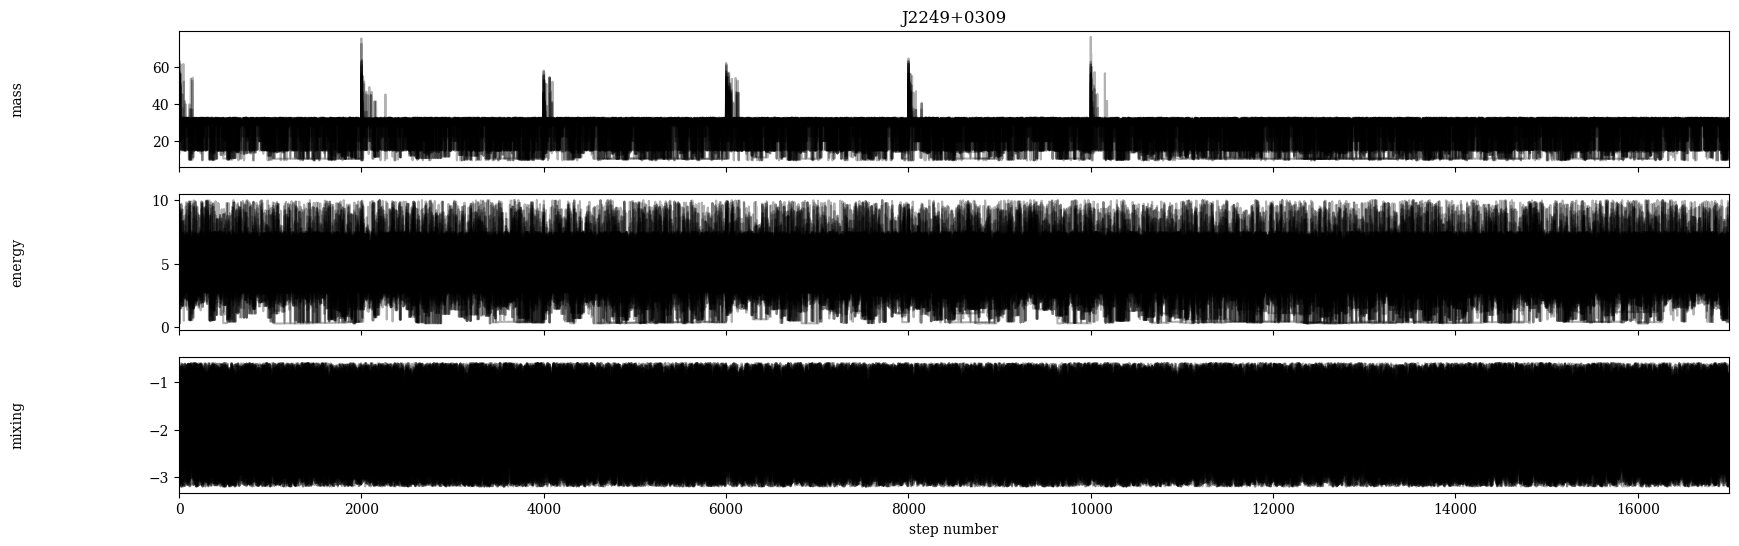

In [9]:
## Plot chains
starname = 'J2249+0309'
resdir = hostdir/'Result/newres'
zero_temp = np.loadtxt(resdir/str_max_ns_dict[maxns]/('loop_%s.txt'%starname)).reshape(30, -1, 3)
zero_temp = np.transpose(zero_temp, (1, 0, 2))
ndims = 3
plot_samples = zero_temp[::1, :, :].copy()
fig, axes = plt.subplots(ndims, figsize=(20, 6), sharex=True)
labels = ['mass', 'energy', 'mixing']
for i in range(ndims):
    ax = axes[i]
    ax.plot(plot_samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, plot_samples.shape[0])
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
# axes[0].set_ylim(9, 19)
axes[-1].set_xlabel("step number")
axes[0].set_title(starname);

In [10]:
# first_num = 23
# for star_idx, star_row in obs_logeps_df.sort_values('Fe').iloc[:first_num].iterrows():
#     starname = star_row.starname
#     # if not starname == 'J2249+0309':
#     # if not starname == 'J0946+1803':
#     #     continue
#     resdir = Path(hostdir)/'Result/newres'/str_max_ns_dict[maxns]
#     zero_temp = np.loadtxt(resdir/('loop_%s.txt'%starname)).reshape(30, -1, 3)
#     zero_temp = np.transpose(zero_temp, (1, 0, 2))
#     zero_temp_samples = zero_temp[-10000:, :, :]
#     flat_samples = zero_temp_samples.reshape(-1, 3)
#     resdir = hostdir/Path('Result/archive_BAF/%s'%starname)
#     pert_samples = np.loadtxt(resdir/'noisesampling_samples.txt')
#     sing = Single(
#         stardir/('%s.dat'%starname), db=db,  
#         z_min=6, z_max=30,
#         upper_lim=False, cdf=False, det=False, 
#         silent=True
#     )
#     bf_index = sing.sorted_stars['index'][0, 0]
#     bf_mass = sing.db[0].fielddata[bf_index]['mass']
    
#     fig, ax = plt.subplots(1, 1, figsize=(10, 6))
#     bins = np.unique(P[:, 0])
#     linewidth = 2
#     subtitle_size = 18
#     linestyle='solid'
#     ax.hist(
#         pert_samples[:, 0], bins=bins, 
#         weights=gen_weight(pert_samples), 
#         cumulative=True, density=True, 
#         histtype='step', linewidth=linewidth, linestyle=linestyle, 
#         color='C0', label='Noise Sampling')
#     ax.hist(
#         flat_samples[-niter:, 0], bins=bins, 
#         # weights=gen_weight(flat_samples[-niter:, :]), 
#         cumulative=True, density=True, 
#         histtype='step', linewidth=linewidth, linestyle=linestyle, 
#         color='C1', label='PTemcee')
#     ax.vlines(
#         bf_mass, 0, 1.2, 
#         colors='k', linestyles='dashed', linewidth=1.5, 
#         label='Best-fit Mass',
#         zorder=5)
#     ax.set_ylim(-.01, 1.05)
#     ax.set_xlim(9, 21)
#     ax.legend()
#     ax.set_title(starname, size=subtitle_size)
#     ax.set_xlabel(r'$\mathrm{Mass}\ M_\odot$', size=subtitle_size)
#     ax.set_ylabel(r'$\mathrm{Cumulative\ Density\ Function}$', size=subtitle_size);
#     # fig.savefig('newfig/%s.pdf'%starname, dpi=300)
#     # plt.close();
#     break

In [11]:
# # starname = 'J0908+3119'
# starname = 'J1035+3158'
# # starname = 'J2249+0309'
# star_idx = np.argwhere(obs_logeps_df.loc[:, 'starname'] == starname)[0, 0]
# O_vec = obs_logeps_df.loc[star_idx, element_list_abvC].values.astype(float)
# eO_vec = obs_elogeps_df.loc[star_idx, element_list_abvC].values.astype(float)
# resdir = hostdir/'Result/newres'
# zero_temp = np.loadtxt(resdir/('loop_%s.txt'%starname)).reshape(30, -1, 3)
# zero_temp = np.transpose(zero_temp, (1, 0, 2))
# zero_temp_samples = zero_temp[-10000:, :, :]
# flat_samples = zero_temp_samples.reshape(-1, 3)
# resdir = hostdir/Path('Result/archive_BAF/%s'%starname)
# pert_samples = np.loadtxt(resdir/'noisesampling_samples.txt')
# sing = Single(
#     stardir/('%s.dat'%starname), db=db,  
#     z_min=6, z_max=30,
#     upper_lim=False, cdf=False, det=False, 
#     silent=True
# )
# bf_index = sing.sorted_stars['index'][0, 0]
# bf_mass = sing.db[0].fielddata[bf_index]['mass']

# fig, ax = plt.subplots(1, 1, figsize=(10, 6))
# bins = np.unique(P[:, 0])
# linewidth = 2
# subtitle_size = 18
# linestyle='solid'
# ax.hist(
#     pert_samples[:, 0], bins=bins, 
#     weights=gen_weight(pert_samples), 
#     cumulative=True, density=True, 
#     histtype='step', linewidth=linewidth, linestyle=linestyle, 
#     color='C0', label='Noise Sampling')
# ax.hist(
#     flat_samples[:, 0], bins=bins, 
#     # weights=1/gen_weight(flat_samples), 
#     cumulative=True, density=True, 
#     histtype='step', linewidth=linewidth, linestyle=linestyle, 
#     color='C1', label='PTemcee')
# ax.vlines(
#     [bf_mass, 22., 22.5], 0, 1.2, 
#     colors='k', linestyles='dashed', linewidth=1.5, 
#     label='Best-fit Mass',
#     zorder=5)
# ax.set_ylim(-.01, 1.05)
# # ax.set_xlim(9, 21)
# ax.legend()
# ax.set_title(starname, size=subtitle_size)
# ax.set_xlabel(r'$\mathrm{Mass}\ M_\odot$', size=subtitle_size)
# ax.set_ylabel(r'$\mathrm{Cumulative\ Density\ Function}$', size=subtitle_size);
# # fig.savefig('newfig/%s.pdf'%starname, dpi=300)
# # plt.close();

In [12]:
# import corner
# corner.corner(
#     flat_samples, 
#     quantiles=[.16, .5, .84], 
#     show_titles=True);
# corner.corner(
#     pert_samples, 
#     quantiles=[.16, .5, .84], 
#     show_titles=True);

# Mass distribution

In [14]:
first_num = 109
niter = 5000
mass_list = []
for star_idx, star_row in obs_logeps_df.sort_values('Fe').iloc[:first_num].iterrows():
    starname = star_row.starname
    resdir = Path(hostdir)/'Result/newres'
    respath = resdir/str_max_ns_dict[maxns]/('loop_%s.txt'%starname)
    tmp_samples = np.loadtxt(respath)
    # break
    tmp_samples = tmp_samples.reshape(30, -1, 3)
    if tmp_samples.shape[1] < 3000:
        # print(tmp_samples.shape)
        continue
    tmp_massdist = tmp_samples[:, -niter::10, 0].reshape(-1)
    mass_list.append(tmp_massdist)
    # break
mass_dist = np.concatenate(mass_list)

In [15]:
np.savetxt(Path(hostdir)/('%s_mass_dist_sample.txt'%str_max_ns_dict[maxns]), mass_dist)
mass_dist = np.loadtxt(Path(hostdir)/('%s_mass_dist_sample.txt'%str_max_ns_dict[maxns]))

In [16]:
p0_dict = {}
nwalker = 50
nstep = 1000
func_form = 'modpw'
ndim = theta_ndim_dict[func_form]
match func_form:
    case 'pw': 
        p0 = np.random.uniform(0, 3, nwalker*ndim).reshape(-1, ndim)
    case 'combine':
        p0 = np.zeros((nwalker, ndim))
        p0[:, 0] = np.random.uniform(0.5, 1, nwalker)
        p0[:, 1] = np.random.uniform(4, 6, nwalker)
        p0[:, 2] = np.random.uniform(0, .5, nwalker)
        p0[:, 3] = np.random.uniform(np.log(20), np.log(30), nwalker)
    case 'modpw':
        p0 = np.zeros((nwalker, ndim))
        p0[:, 0] = np.random.uniform(1, 1.5, nwalker)
        p0[:, 1] = np.random.uniform(1.5, 2.5, nwalker)
        p0[:, 2] = np.random.uniform(3, 5, nwalker)
p0_dict[func_form] = p0

100%|██████████| 1000/1000 [1:10:28<00:00,  4.23s/it]


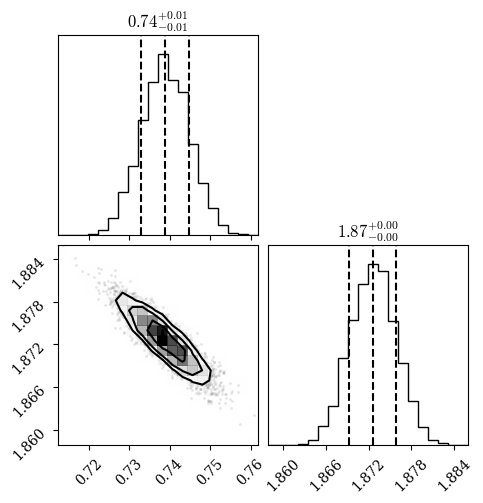

In [17]:
log_likelihood = log_likelihood_dict[func_form]
ndim = theta_ndim_dict[func_form]
p0 = p0_dict[func_form]
with Pool(max_workers=50) as pool:
    if func_form == 'modpw':
        sampler = emcee.EnsembleSampler(
            nwalker, ndim, log_likelihood, args=(mass_dist, maxns, ), pool=pool)
    else:
        sampler = emcee.EnsembleSampler(
            nwalker, ndim, log_likelihood, args=(mass_dist, ), pool=pool)
    sampler.run_mcmc(p0, nstep, progress=True)
match func_form:
    case 'pw':
        samples = sampler.get_chain(discard=100, thin=15, flat=True)[:, :-1]
    case 'combine':
        samples = sampler.get_chain(discard=100, thin=15, flat=True)[:, :]
    case 'modpw':
        samples = sampler.get_chain(discard=100, thin=15, flat=True)[:, :-1]
fig = corner.corner(
    samples, 
    show_titles=True, plot_datapoints=True, 
    quantiles=[0.16, 0.5, 0.84]
)
theta = np.quantile(samples, q=[.5], axis=0).reshape(-1)

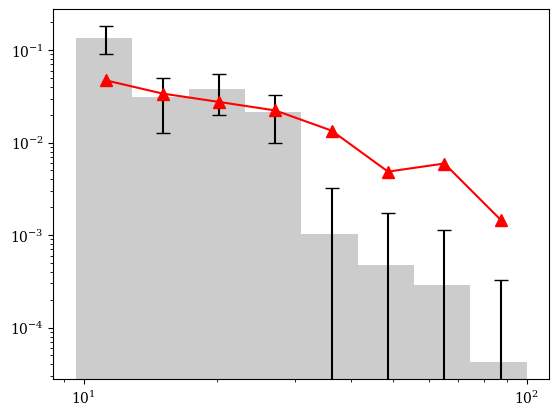

In [28]:
# bins = np.unique(P[:, 0])
maxns = 2.0
gridM = gridM_dict['znuc2012S4']
hist_color, mod_color, std_color = 'k', 'red', 'k'
bins = np.logspace(np.log10(9.6), np.log10(100), 9)
# lin_bins = np.linspace(9.6, 100, 11)
bins_mid = np.diff(bins)/2+bins[:-1]
binsize = np.diff(bins)
best_theta = theta
# best_theta[1] = 0

plt.figure()
hist, _, _ = plt.hist(
    mass_dist, bins=bins, 
    cumulative=False, density=True, 
    color=hist_color, alpha=.2
)
yerr = np.ma.sqrt(hist/(len(mass_dist)/(niter/100*30))/binsize)
plt.errorbar(
    bins_mid, hist, yerr=yerr, 
    c=hist_color, ls='none', capsize=5, zorder=1)

# modified powerlaw
prob_hist = np.zeros(len(hist))
prob = gen_exprobmat(np.append(best_theta, 3), maxns)['znuc2012S4']
nst_binmid_arg = np.argmin(np.abs(gridM-bins_mid[:, None]), axis=0)
for tmp_idx, tmp_arg in enumerate(nst_binmid_arg):
    prob_hist[tmp_arg] += (prob[tmp_idx])
prob_hist /= binsize
plt.plot(
    bins_mid, prob_hist, c=mod_color, linestyle='-', marker='^', markersize=8, zorder=2, 
    label='$\\alpha_m=%.2f,\\alpha_e=%.2f$'%(best_theta[0], best_theta[1]))
plt.xscale('log')
plt.yscale('log');